In [27]:
import ccxt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
creds = json.loads(open('../creds.json', 'r').read())

In [279]:
exchange = ccxt.binance(creds['binance'])

In [280]:
exchange.rateLimit

500

In [281]:
exchange.enableRateLimit = True

## We fetch the last BTC tickers from Binance

In [296]:
candles = np.array(exchange.fetch_ohlcv("BTC/USDT", '5m'))
n = candles.shape[0]

In [259]:
for _ in range(4):
    candles2 = np.array(exchange.fetch_ohlcv("BTC/USDT", '1h', int(candles[0, 0] - n * 60 * 60 * 1000)))
    candles = np.vstack([candles2, candles])

In [297]:
data = pd.DataFrame()
data['timestamp'] = candles[:, 0]
data['date'] = pd.to_datetime(data['timestamp'] * 1000000)
data['open'] = candles[:, 1]
data['high'] = candles[:, 2]
data['low'] = candles[:, 3]
data['close'] = candles[:, 4]
data['volume'] = candles[:, 5]

## MACD calculation

In [298]:
ewm12 = data['close'].ewm(span=12, adjust=False).mean()
ewm26 = data['close'].ewm(span=26, adjust=False).mean()
macd = ewm12 - ewm26
macd9 = macd.ewm(span=9, adjust=False).mean()
data['macd'] = macd
data['macd9'] = macd9

In [299]:
data

,timestamp,date,open,high,low,close,volume,macd,macd9
0,1.615088e+12,2021-03-07 03:35:00,49611.00,49740.00,49602.37,49642.39,114.724640,0.000000,0.000000
1,1.615088e+12,2021-03-07 03:40:00,49646.76,49753.07,49602.61,49732.99,110.660646,7.227350,1.445470
2,1.615089e+12,2021-03-07 03:45:00,49732.99,49771.41,49638.53,49658.56,98.845162,6.870006,2.530377
3,1.615089e+12,2021-03-07 03:50:00,49658.56,49658.56,49486.96,49575.40,362.618922,-0.122102,1.999881
4,1.615089e+12,2021-03-07 03:55:00,49575.40,49581.32,49433.88,49551.44,269.285988,-7.510197,0.097866
...,...,...,...,...,...,...,...,...,...
495,1.615237e+12,2021-03-08 20:50:00,51863.37,51996.58,51615.98,51623.75,505.791546,197.424484,165.699434
496,1.615237e+12,2021-03-08 20:55:00,51621.12,51819.00,51616.93,51759.63,256.971708,200.645753,172.688698
497,1.615237e+12,2021-03-08 21:00:00,51762.77,51899.99,51741.02,51749.94,175.744392,200.109986,178.172955
498,1.615238e+12,2021-03-08 21:05:00,51749.93,51754.50,51514.29,51633.04,333.163053,188.084414,180.155247


## MACD crossovers calculations

In [300]:
macd9_shifted = data['macd9'].shift(1)
macd_shifted = data['macd'].shift(1)

crossovers_buy = (macd_shifted < macd9_shifted) & (data['macd'] >= data['macd9'])
data['crossover_buy'] = crossovers_buy

crossovers_sell = (macd_shifted > macd9_shifted) & (data['macd'] <= data['macd9'])
data['crossover_sell'] = crossovers_sell

## Plotting everything

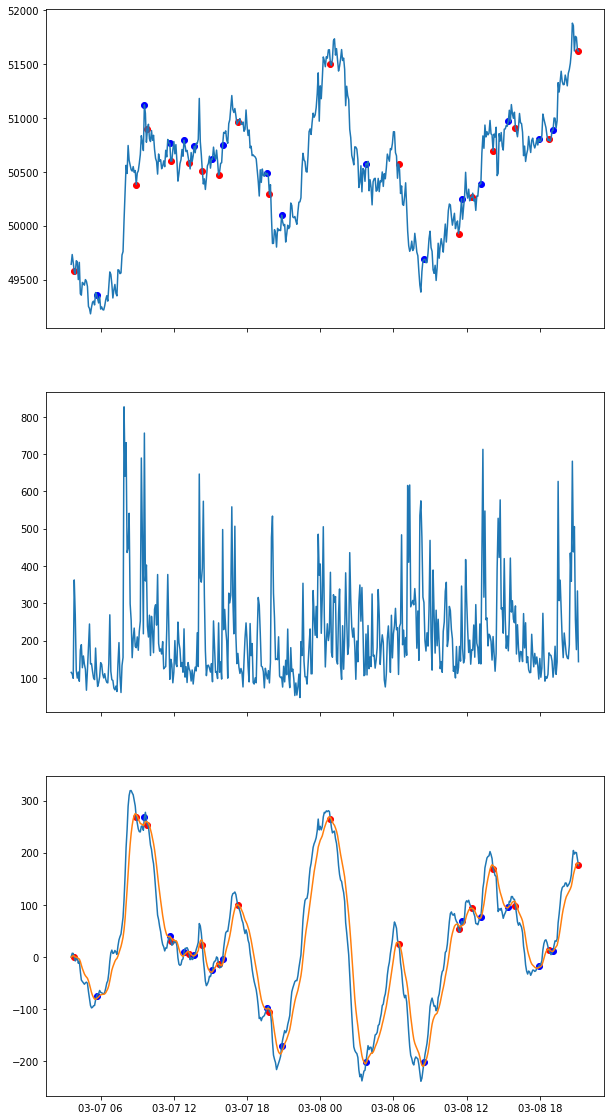

In [301]:
import matplotlib.dates as mdates
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 20))
ax1.plot(data['date'], data['close'])
ax2.plot(data['date'], data['volume'])
ax3.plot(data['date'], data['macd'])
ax3.plot(data['date'], data['macd9'])
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for index, row in data.iterrows():
    if (row['crossover_buy']):
        ax3.scatter(row['date'], row['macd'], color='b')
        ax1.scatter(row['date'], row['close'], color='b')
    if (row['crossover_sell']):
        ax3.scatter(row['date'], row['macd'], color='r')
        ax1.scatter(row['date'], row['close'], color='r')

plt.show()

## Calculating estimated profit

In [303]:
profits = []

last_buy = None
for index, row in data.iterrows():
    if (row['crossover_buy'] and not last_buy):
        last_buy = (row['open'] + row['close']) / 2
        print("Buy @{:.2f}".format(last_buy))
    if (row['crossover_sell'] and last_buy):
        price = (row['open'] + row['close']) / 2
        variation = (price - last_buy) / last_buy * 100
        profits.append(variation - 0.065)
        last_buy = None
        print("Sell @{:.2f}, profit {:.2f}".format(price, profits[-1]))
print("Total: {:.2f}".format(np.array(profits).sum()))

Buy @49369.95
Sell @50446.74, profit 2.12
Buy @50911.31
Sell @50836.56, profit -0.21
Buy @50770.68
Sell @50683.01, profit -0.24
Buy @50720.85
Sell @50612.54, profit -0.28
Buy @50692.89
Sell @50585.07, profit -0.28
Buy @50619.29
Sell @50536.65, profit -0.23
Buy @50668.18
Sell @50952.54, profit 0.50
Buy @50479.55
Sell @50370.55, profit -0.28
Buy @50027.06
Sell @51569.85, profit 3.02
Buy @50496.10
Sell @50507.47, profit -0.04
Buy @49680.72
Sell @49985.88, profit 0.55
Buy @50188.58
Sell @50264.62, profit 0.09
Buy @50388.40
Sell @50771.65, profit 0.70
Buy @50948.18
Sell @50984.00, profit 0.01
Buy @50779.76
Sell @50798.64, profit -0.03
Buy @50885.97
Sell @51627.52, profit 1.39
Total: 6.77


In [304]:
len(profits) / (data.shape[0] / 24)

0.768

In [305]:
np.array(profits).mean()

0.42342972850684185